## READ FILE


In [1]:
import numpy as np
import pandas as pd

class ProductionData:
    def __init__(self, demand_forecast, setup_cost, production_cost, holding_cost, num_periods):
        self.demand_forecast = np.array(demand_forecast)
        self.setup_cost = np.array(setup_cost)
        self.production_cost = np.array(production_cost)
        self.holding_cost = np.array(holding_cost)
        self.num_periods = num_periods
    
    def __repr__(self):
        return (f"ProductionData(\n"
                f"  Demand Forecast: {self.demand_forecast}\n"
                f"  Setup Cost: {self.setup_cost}\n"
                f"  Production Cost: {self.production_cost}\n"
                f"  Holding Cost: {self.holding_cost}\n"
                f"  Number of Periods: {self.num_periods}\n")

def read_production_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Insert dummy period 0
    demand_forecast = np.insert(df["Demand Forecast"].to_numpy(), 0, 0)
    setup_cost = np.insert(df["Setup Cost"].to_numpy(), 0, 0)
    production_cost = np.insert(df["Production cost"].to_numpy(), 0, 0)
    holding_cost = np.insert(df["Holding cost"].to_numpy(), 0, 0)
    
    num_periods = df.shape[0]
    
    return ProductionData(demand_forecast, setup_cost, production_cost, holding_cost, num_periods)

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]



In [ ]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]

# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read data using the function
    data = read_production_data(file_path, sheet_name)

    T = data.num_periods
    print(f"Number of periods: {T}")

    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    b = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="b")  # Amount backlogged at the end of period t

    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * b[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")
    model.addConstr(b[0] == 0, name="no_backlogging0")
    model.addConstr(b[T] == 0, name="no_backloggingT")

    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] - b[t-1] == data.demand_forecast[t] + S[t] - b[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= (quicksum(data.demand_forecast[m] for m in range(t, T+1)) - b[t]) * y[t], name=f"setup_constraint_{t}")

    # Solve model
    model.optimize()

    # Check if the model found an optimal solution
    if model.status == GRB.OPTIMAL:
        print("\nOptimal solution found:")
        # Create a temporary DataFrame for the current sheet results
        sheet_results = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S", "b"])
        for t in range(1, T+1):
            # Store the results for the current sheet
            sheet_results = pd.concat([sheet_results, pd.DataFrame([{
                "Sheet": sheet_name,
                "Period": t,
                "y": y[t].X,
                "x": x[t].X,
                "S": S[t].X,
                "b": b[t].X
            }])], ignore_index=True)
        
        # Concatenate the results for all sheets
        results_df = pd.concat([results_df, sheet_results], ignore_index=True)

    else:
        print(f"No optimal solution found for sheet {sheet_name}.")

# Save results to a CSV file
results_df.to_csv("val_backlog_results.csv", index=False)
print("\nResults have been saved to 'optimization_results.csv'.")



Processing sheet: 6-periods (1)
Number of periods: 6
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 10 rows, 28 columns and 34 nonzeros
Model fingerprint: 0x758294a8
Model has 6 quadratic constraints
Variable types: 21 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 21 rows, 36 columns, 64 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 25 continuous, 11 integer (11 binary)
Found heuristic

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{
C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, sheet_results], ignore_index=True)


  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 9e+02]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 21 rows, 36 columns, 64 nonzeros
Presolved model has 10 SOS constraint(s)
Variable types: 25 continuous, 11 integer (11 binary)
Found heuristic solution: objective 146785.00048

Root relaxation: objective 1.050790e+05, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    105079.00000 105079.000  0.00%     -    0s

Explored 1 nodes (6 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 105079 146785 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.050790000000e+05, best bound 1.050790000000e+05, gap 0.0000%

Optimal solution found:

Processing sheet: 12-periods (1)
Number of periods: 12
Gurobi Opti

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Best objective 5.274800000000e+04, best bound 5.274800000000e+04, gap 0.0000%

Optimal solution found:

Processing sheet: 12-periods (2)
Number of periods: 12
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 16 rows, 52 columns and 64 nonzeros
Model fingerprint: 0xebc4d2fe
Model has 12 quadratic constraints
Variable types: 39 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+03]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 1e+03]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 45 rows, 78 columns, 142 nonzeros
P

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{



Optimal solution found (tolerance 1.00e-04)
Best objective 4.479300000000e+04, best bound 4.479300000000e+04, gap 0.0000%

Optimal solution found:

Processing sheet: 24-periods (1)
Number of periods: 24
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 28 rows, 100 columns and 124 nonzeros
Model fingerprint: 0x7fdc41d0
Model has 24 quadratic constraints
Variable types: 75 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 9e+02]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 72628.8558    0   16 496677.004 72628.8558  85.4%     -    0s
H    0     0                    77184.000000 72628.8558  5.90%     -    0s
H    0     0                    76850.000000 76696.0000  0.20%     -    0s
*    0     0               0    76696.000000 76696.0000  0.00%     -    0s

Cutting planes:
  Gomory: 13
  Implied bound: 11
  Flow cover: 3
  Network: 2
  Relax-and-lift: 6

Explored 1 nodes (64 simplex iterations) in 0.10 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 76696 76850 77184 496677 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.669600000000e+04, best bound 7.669600000000e+04, gap 0.0000%

Optimal solution found:

Processing sheet: 24-periods (2)
Number of periods: 24
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{



Root relaxation: objective 8.868770e+04, 52 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 88687.6969    0   16 579652.004 88687.6969  84.7%     -    0s
H    0     0                    157407.00000 88687.6969  43.7%     -    0s
H    0     0                    154266.00000 88687.6969  42.5%     -    0s
H    0     0                    152592.00000 88687.6969  41.9%     -    0s
H    0     0                    148671.00000 88687.6969  40.3%     -    0s
H    0     0                    147281.00000 88687.6969  39.8%     -    0s
H    0     0                    146997.00000 112331.571  23.6%     -    0s
H    0     0                    144486.00000 112331.571  22.3%     -    0s
     0     0 112331.571    0   11 144486.000 112331.571  22.3%     -    0s
H    0     0                    128881.00000 112896.211  12.4%     -    0s
     0    

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Optimize a model with 56 rows, 212 columns and 264 nonzeros
Model fingerprint: 0x9a317b6c
Model has 52 quadratic constraints
Variable types: 159 continuous, 53 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+04]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 205 rows, 358 columns, 662 nonzeros
Presolved model has 102 SOS constraint(s)
Variable types: 255 continuous, 103 integer (103 binary)

Root relaxation: objective 1.379289e+05, 115 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 137928.896    0   38          - 137928.896      -     -    0s
H    0     0                    303061.00000 137928.896  54.5%     -   

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


     0     0 132871.432    0   36          - 132871.432      -     -    0s
H    0     0                    295890.00000 132871.432  55.1%     -    0s
H    0     0                    291349.00000 132871.432  54.4%     -    0s
H    0     0                    291011.00000 132871.432  54.3%     -    0s
H    0     0                    279903.00000 132871.432  52.5%     -    0s
H    0     0                    236316.00000 175800.449  25.6%     -    0s
     0     0 175800.449    0   28 236316.000 175800.449  25.6%     -    0s
H    0     0                    230639.00000 176161.013  23.6%     -    0s
H    0     0                    227451.00000 176291.398  22.5%     -    0s
     0     0 178863.356    0   31 227451.000 178863.356  21.4%     -    0s
H    0     0                    222555.00000 178863.356  19.6%     -    0s
     0     0 191716.564    0   28 222555.000 191716.564  13.9%     -    0s
H    0     0                    219175.00000 191716.564  12.5%     -    0s
     0     0 191935.601  

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{



CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 108 rows, 420 columns and 524 nonzeros
Model fingerprint: 0x6a7d9e1d
Model has 104 quadratic constraints
Variable types: 315 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 5e+04]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 6 rows and 10 columns
Presolve time: 0.00s
Presolved: 411 rows, 719 columns, 1331 nonzeros
Presolved model has 206 SOS constraint(s)
Variable types: 513 continuous, 206 integer (206 binary)

Root relaxation: objective 2.215371e+05, 257 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Ob

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 108 rows, 420 columns and 524 nonzeros
Model fingerprint: 0x4e05e601
Model has 104 quadratic constraints
Variable types: 315 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 5e+04]
  Objective range  [1e+00, 5e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 413 rows, 722 columns, 1338 nonzeros
Presolved model has 206 SOS constraint(s)
Variable types: 515 continuous, 207 integer (207 binary)

Root relaxation: objective 4.064174e+05, 265 itera

C:\Users\irako\AppData\Local\Temp\ipykernel_10980\2487466693.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sheet_results = pd.concat([sheet_results, pd.DataFrame([{


In [ ]:
import matplotlib.pyplot as plt

# Generate and save histograms for each sheet
for sheet_name in results_df["Sheet"].unique():
    sheet_data = results_df[results_df["Sheet"] == sheet_name]

    plt.figure(figsize=(8, 5))
    plt.bar(sheet_data["Period"], sheet_data["y"], color='blue', alpha=0.7)
    plt.xlabel("Period")
    plt.ylabel("Inventory Level (S)")
    plt.title(f"Inventory Levels for {sheet_name}")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save histogram as an image
    hist_filename = f"histogram_{sheet_name.replace(' ', '_')}.png"
    plt.savefig(hist_filename)
    print(f"Histogram saved: {hist_filename}")
    plt.close()

## 10.1 Pattern Observation in MILP

Large backlogs are observed at the start of most of the instancs in the MILP solution. This is expected as the model's strategy to minimize setup and production costs. Since the backlogging costs are significantly lower that other costs, the model delays production to avoid high setup costs in the early periods, leading to an accumulation of backlog. As production ramps up in later periods, the backlog decreases. This behavior reflects the natural trade-offs between setup, production, and backlog costs.

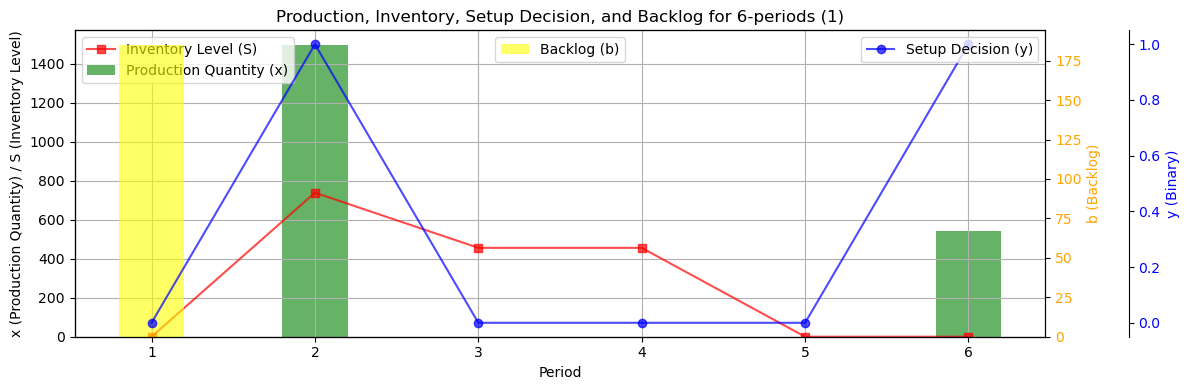

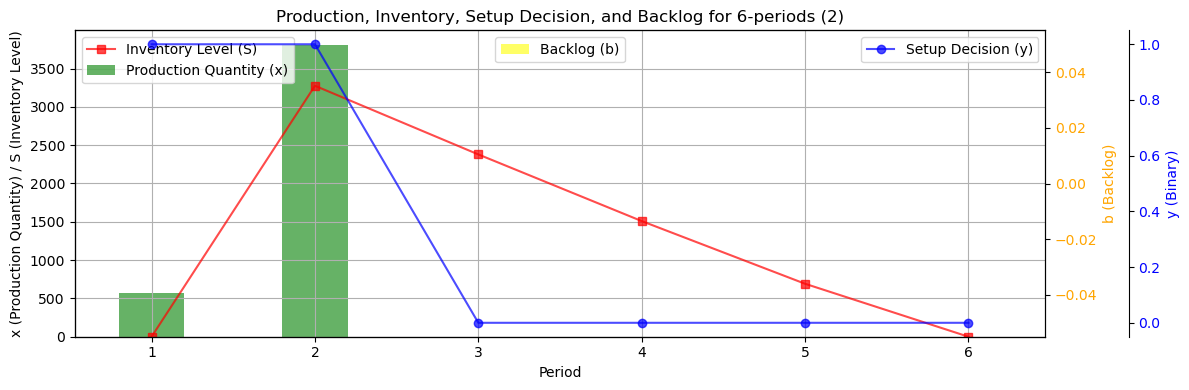

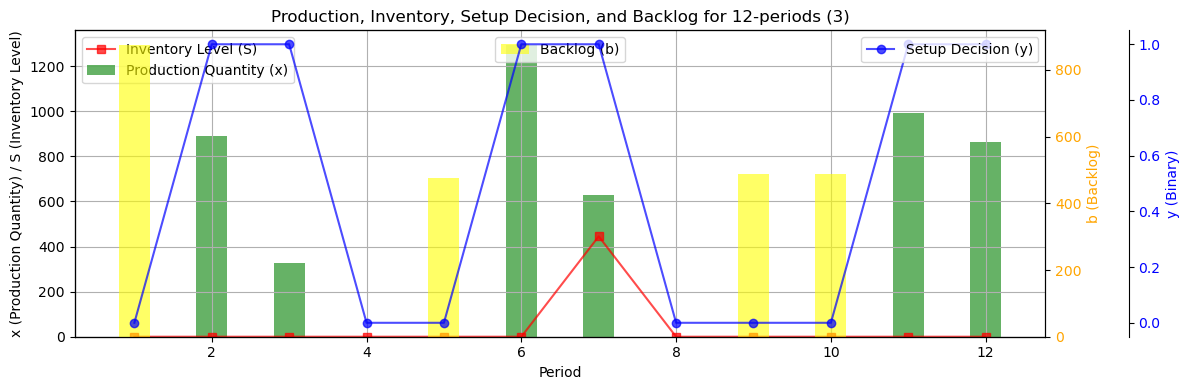

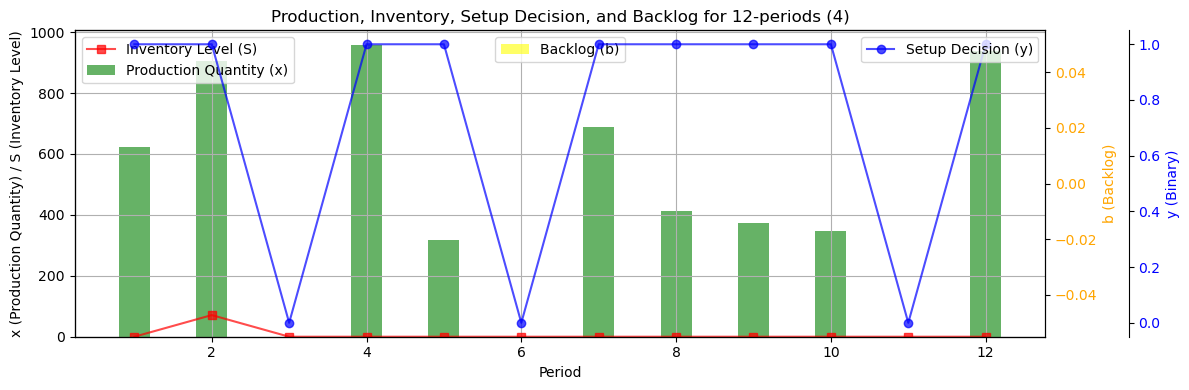

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the all_results CSV file into a DataFrame
results_df = pd.read_csv("Val_backlog_results.csv")

# Define function to plot data
def plot_data(data, sheet_name):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Plot production quantity (x) as a bar chart
    ax1.bar(data['Period'], data['x'], color='g', width=0.4, label='Production Quantity (x)', alpha=0.6)
    
    # Plot inventory level (S) as a red line
    ax1.plot(data['Period'], data['S'], marker='s', linestyle='-', color='r', label='Inventory Level (S)', alpha=0.7)
    
    ax1.set_xlabel('Period')
    ax1.set_ylabel('x (Production Quantity) / S (Inventory Level)')
    ax1.tick_params(axis='y')

    # Create a second y-axis for backlog (b)
    ax2 = ax1.twinx()
    
    # Plot backlog (b) as a yellow block (bar)
    ax2.bar(data['Period'], data['b'], color='yellow', label='Backlog (b)', alpha=0.6, width=0.4)
    ax2.set_ylabel('b (Backlog)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Create a third y-axis for setup decision (y)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Shift the third axis to avoid overlap
    
    # Plot setup decision (y) as a blue line
    ax3.plot(data['Period'], data['y'], marker='o', linestyle='-', color='b', label='Setup Decision (y)', alpha=0.7)
    ax3.set_ylabel('y (Binary)', color='b')
    ax3.tick_params(axis='y', labelcolor='b')

    plt.title(f'Production, Inventory, Setup Decision, and Backlog for {sheet_name}')
    ax1.grid(True)
    
    # Adding legends for all three y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper center')
    ax3.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Split the CSV into instances
sheet_ranges = [
    ("6-periods (1)", 0, 6),
    ("6-periods (2)", 6, 12),
    ("12-periods (3)", 12, 24),
    ("12-periods (4)", 24, 36)
]

for sheet_name, start_row, end_row in sheet_ranges:
    sheet_data = results_df.iloc[start_row:end_row]
    plot_data(sheet_data, sheet_name)
